In [ ]:
Name  :Yoneshwar Babu 
ASU ID:1220454365

![](DOPR1P1.png)


In [37]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [38]:

# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [39]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [40]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential( #sequwential ntwork with
            nn.Linear(dim_input, dim_hidden), #linear
            nn.Tanh(), #nonlinear hyberbolic tangent function
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [41]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [42]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD(stochastic gradient descent) and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.02)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()

[1] loss: 1.412


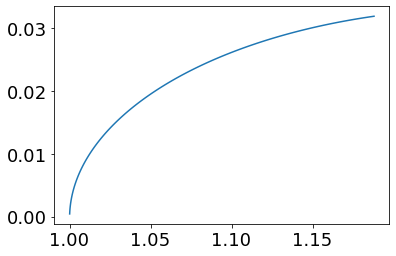

[2] loss: 0.478


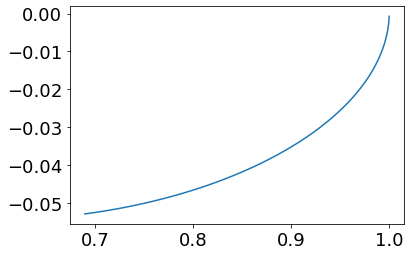

[3] loss: 0.175


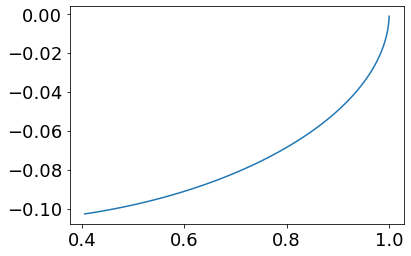

[4] loss: 0.080


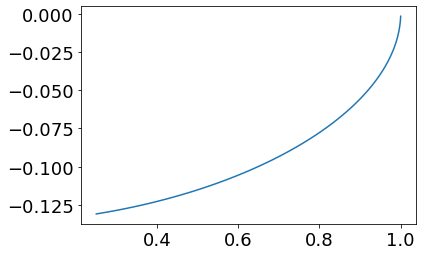

[5] loss: 0.049


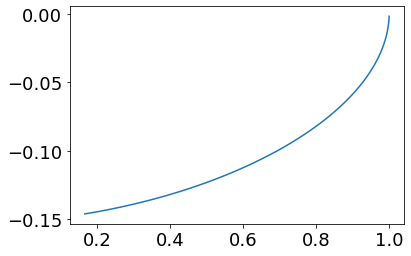

[6] loss: 0.038


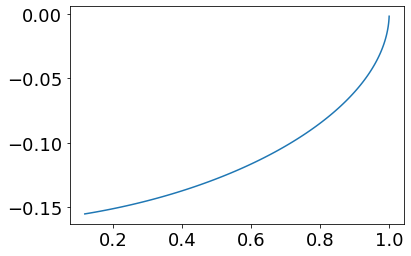

[7] loss: 0.033


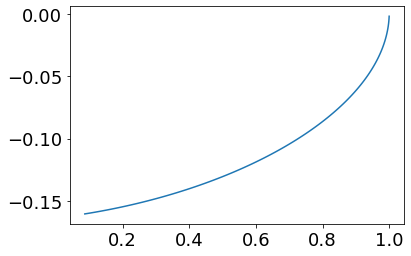

[8] loss: 0.031


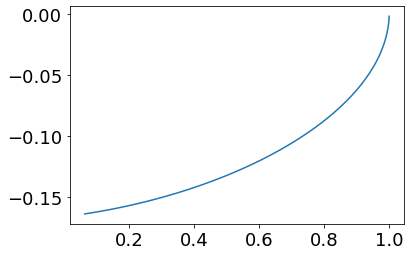

[9] loss: 0.030


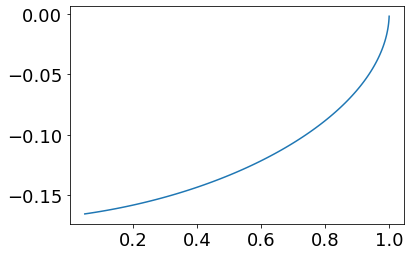

[10] loss: 0.029


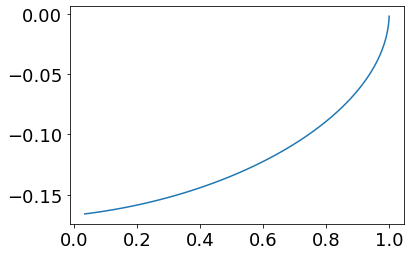

[11] loss: 0.028


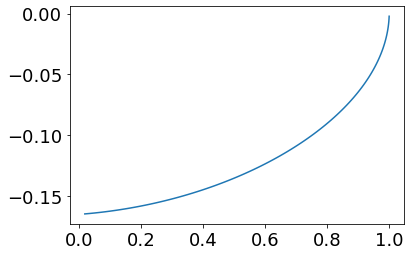

[12] loss: 0.026


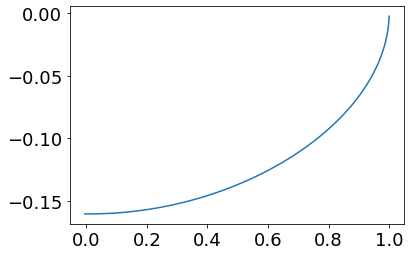

[13] loss: 0.004


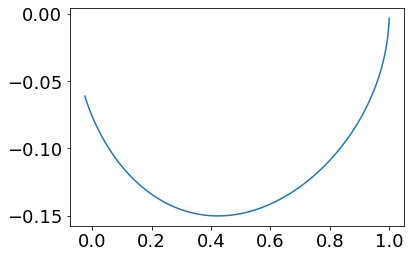

[14] loss: 0.002


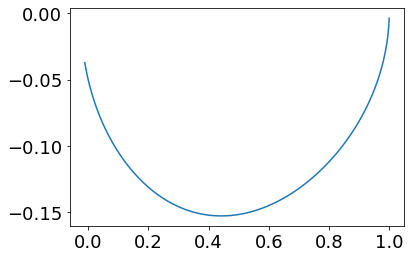

[15] loss: 0.001


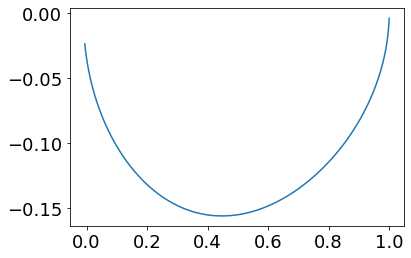

[16] loss: 0.000


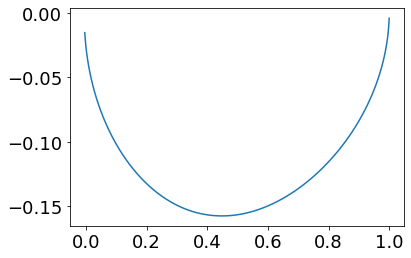

[17] loss: 0.000


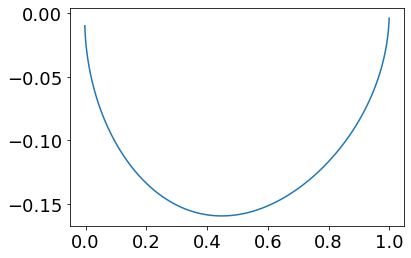

[18] loss: 0.000


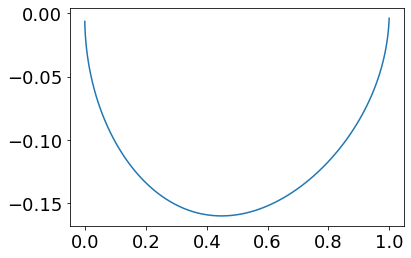

[19] loss: 0.000


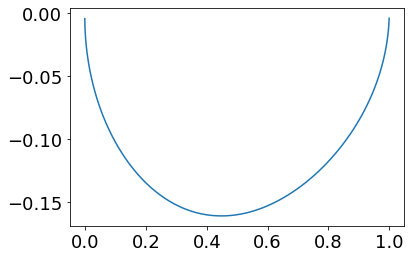

[20] loss: 0.000


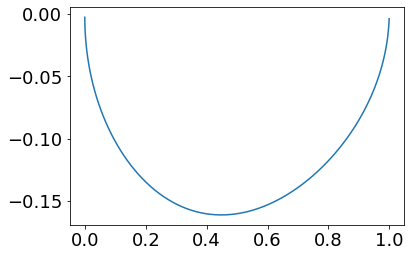

[21] loss: 0.000


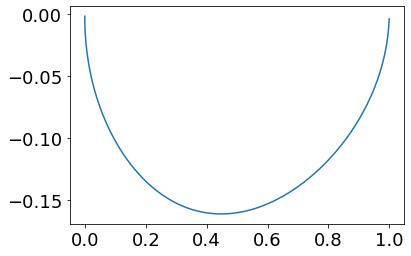

[22] loss: 0.000


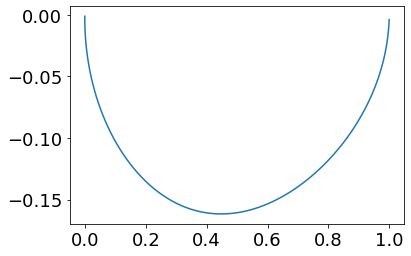

[23] loss: 0.000


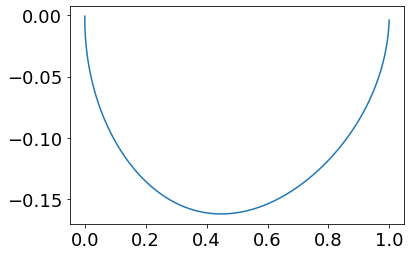

[24] loss: 0.000


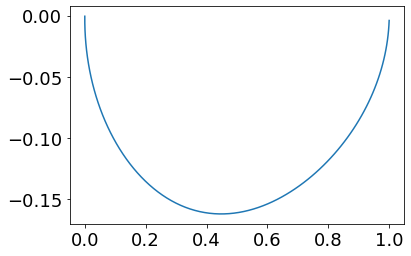

[25] loss: 0.000


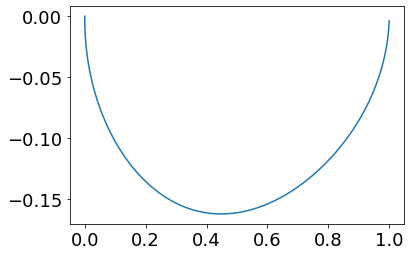

[26] loss: 0.000


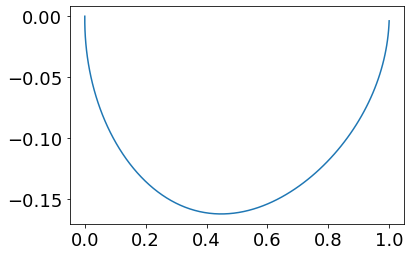

[27] loss: 0.000


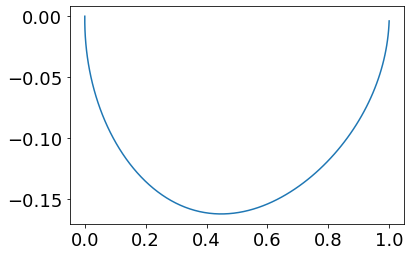

[28] loss: 0.000


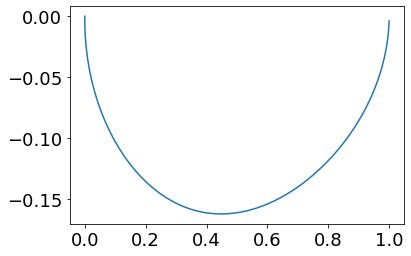

[29] loss: 0.000


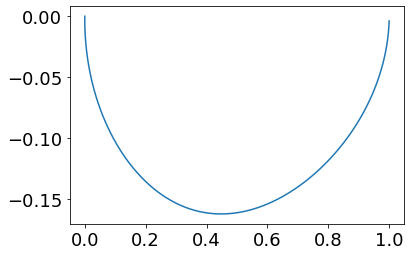

[30] loss: 0.000


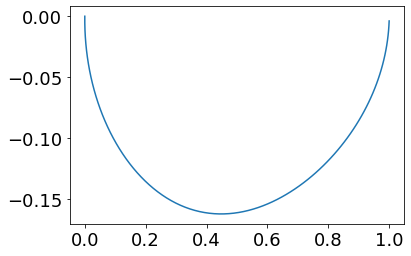

[31] loss: 0.000


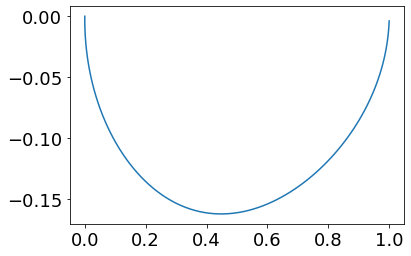

[32] loss: 0.000


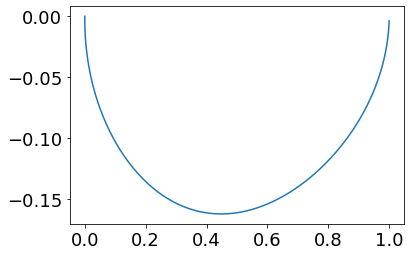

[33] loss: 0.000


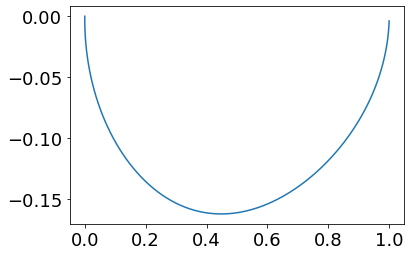

[34] loss: 0.000


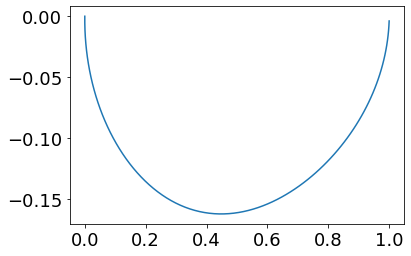

[35] loss: 0.000


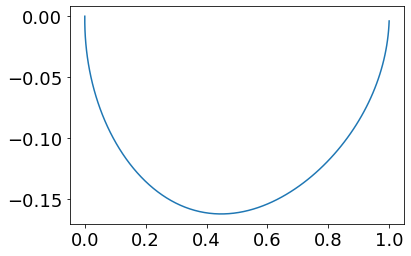

[36] loss: 0.000


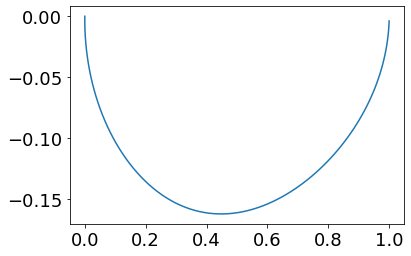

[37] loss: 0.000


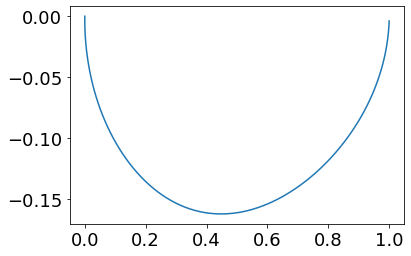

[38] loss: 0.000


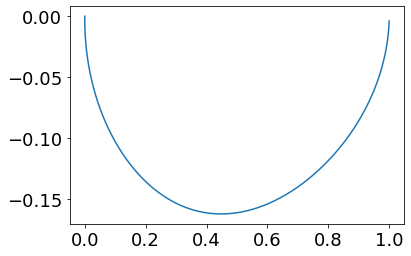

[39] loss: 0.000


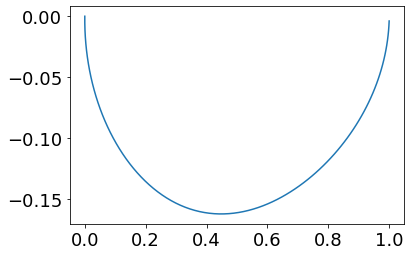

[40] loss: 0.000


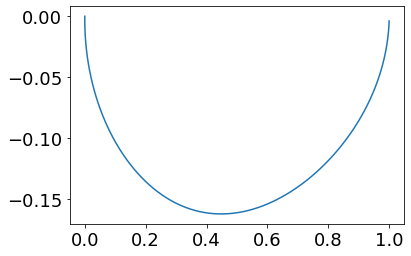

In [43]:

# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem


second try

In [27]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)


In [28]:
# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = 9.8  # m/s2, gravity constant
BOOST_ACCEL = 12.0  # m/s2, thrust constant
#drag=0.5

In [29]:
# defining the dynamics of system

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action:
        action[0]: thrust in x direction. range (0, 1). 
                    1 = maximum thrust. 
                    0 = minimum thrust i.e zero.
          
        with respect to graph  
          
        action[1]: thrust in the direction of y axis. range (0, 1).
                   here at 0.5 there is no thrust, at 0 there is thrust in left side and at 1 thrust is in right side. 
        
        states:
        state[0] = x
        state[1] = xd_v velocity in x direction
        state[2] = y
        state[3] = yd_v velocity in y direction
        state[4] = fuel
        state[5] = drag
        state[6] = 
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed...
        # Taking gravity into consideration       
        delta_state_gravity = -t.tensor([0., 0., 0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust of x and y directions are calculated respectively
        thrust_x = action[0]*2.0-1.0
        thrust_y = action[1]
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1.0 , 0., 0.]) * thrust_x
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0. , 0., 1.0]) * thrust_y
        
        # Update velocity, both gravity, thrust of x and y are used
        state = state + delta_state_x + delta_state_y + delta_state_gravity
        
        # Update state 
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [30]:
# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),#
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


In [31]:
# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of the rocket is set at (10, 20) with zero initial velocity
        state = [10.0, -2.0, 20.0, 1.0]  
        return t.tensor(state, requires_grad=False).float()

    # calculation of the loss function
    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [32]:
# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of the rocket is set at (10, 20) with zero initial velocity
        state = [10.0, -2.0, 20.0, 1.0]  
        return t.tensor(state, requires_grad=False).float()

    # calculation of the loss function
    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2


In [33]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.008)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch % 5 == 0:
                self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x1 = data[:, 0]
        v_x = data[:, 1]
        y1 = data[:, 2]
        v_y = data[:, 3]
        tt = range(self.simulation.T)
        data1 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        thrust_xx = data1[:, 0]
        thrust_yy = data1[:, 1]
        
        fig, graph = plt.subplots(1, 3, figsize=(20, 7))
        
        graph[0].plot(x1, y1)
        graph[0].plot(10, 20, '-ro', c='g', label='start')
        graph[0].plot(0, 0, '-ro', c='r', label='destination')
        graph[0].set_xlabel('x (m)')
        graph[0].set_ylabel('y (m)')
        graph[0].set(title='Displacement plot')
        graph[0].grid()
        graph[0].legend()
        
        
        graph[1].plot(tt, v_x, c='g', label='x velocity')
        graph[1].plot(tt, v_y, c='r', label='y velocity')
        graph[1].set_xlabel('frame (0.1s)')
        graph[1].set_ylabel('v (m/s)')
        graph[1].set(title='Velocity plot')
        graph[1].grid()
        graph[1].legend()
        
        
        graph[2].plot(tt, thrust_xx, c='g', label='x thrust')
        graph[2].plot(tt, thrust_yy, c='r', label='y thrust')
        graph[2].set_xlabel('frame (0.1s)')
        graph[2].set_ylabel('thrust status')
        graph[2].set(title='Thrust plot')
        graph[2].grid()
        graph[2].legend()
           
        fig.tight_layout()
        plt.rcParams.update({'font.size': 18})
        plt.show()

In [26]:
        plt.plot(tt, v_x, c='g', label='x velocity')
        plt.plot(tt, v_y, c='r', label='y velocity')
        plt.set_xlabel('frame (0.1s)')
        plt.set_ylabel('v (m/s)')
        plt.set(title='Velocity plot')
        plt.grid()
        plt.legend()

NameError: name 'tt' is not defined

In [15]:
        plt.plot(tt, thrust_xx, c='g', label='x thrust')
        plt.plot(tt, thrust_yy, c='r', label='y thrust')
        plt.set_xlabel('frame (0.1s)')
        plt.set_ylabel('thrust status')
        plt.set(title='Thrust plot')
        plt.grid()
        plt.legend()
           
        plt.rcParams.update({'font.size': 18})
        plt.show()

NameError: name 'tt' is not defined

[1] loss: 8406.071


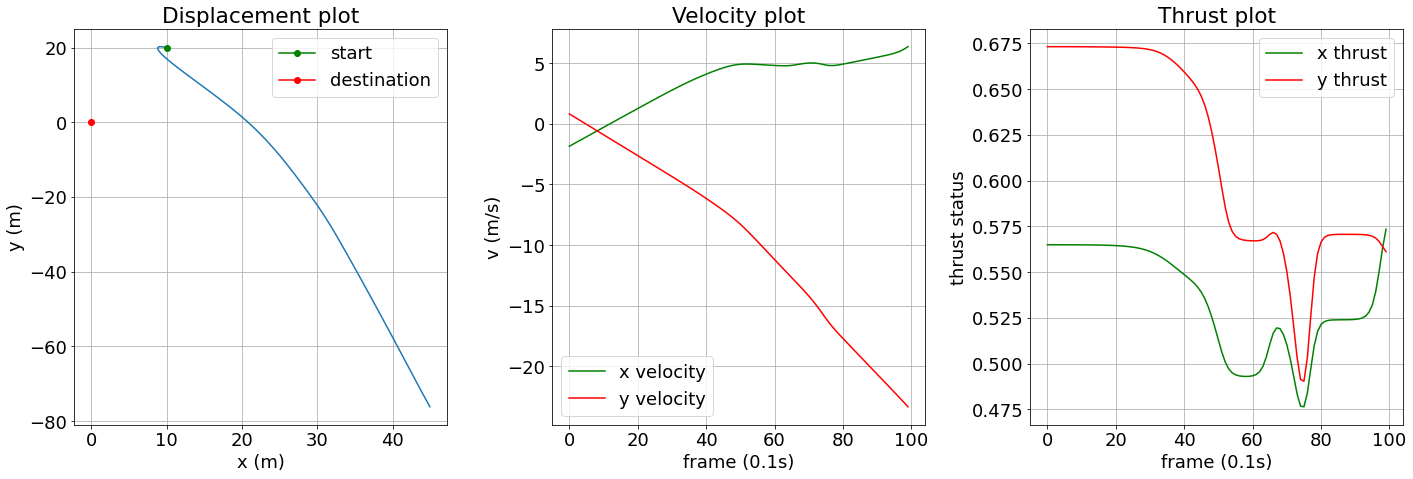

[2] loss: 3425.070
[3] loss: 1704.048
[4] loss: 900.954
[5] loss: 521.199
[6] loss: 338.923


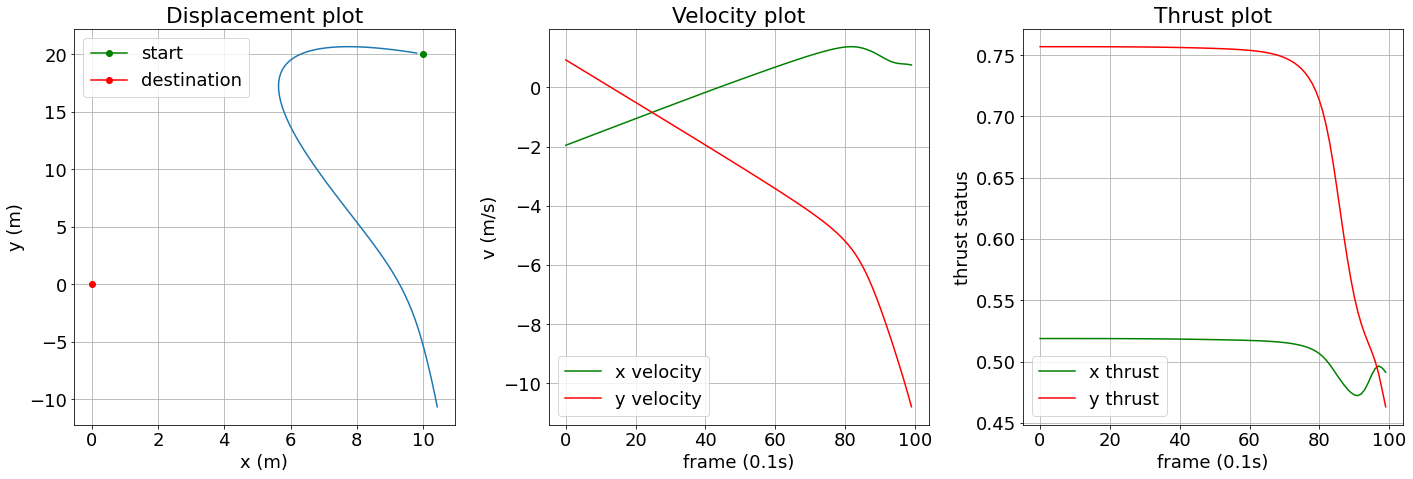

[7] loss: 238.016
[8] loss: 174.224
[9] loss: 129.311
[10] loss: 94.018
[11] loss: 71.099


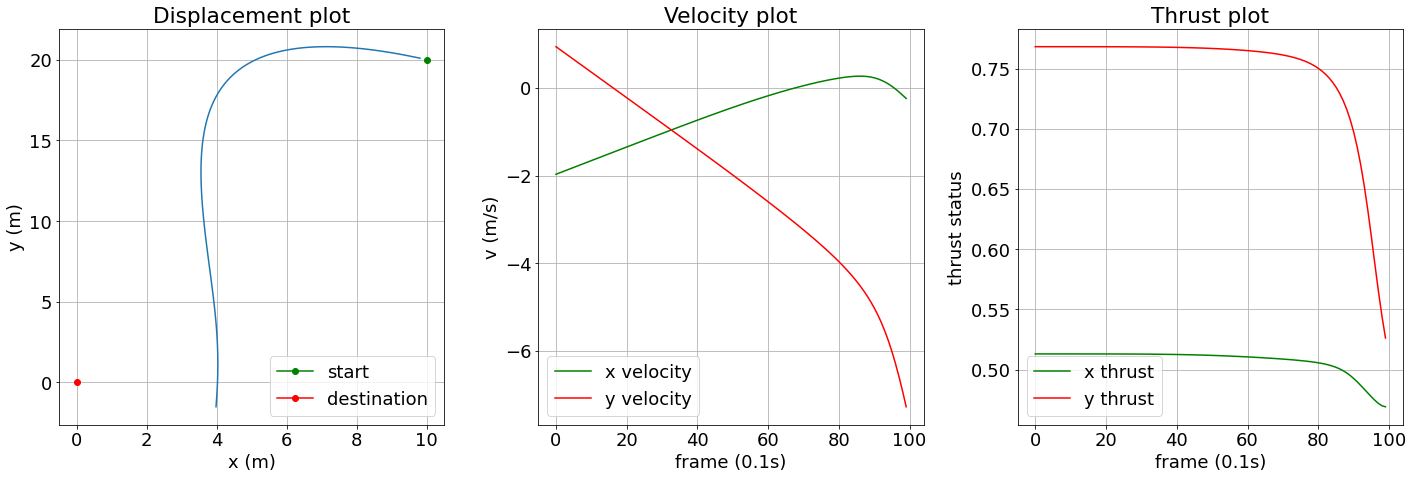

[12] loss: 59.097
[13] loss: 52.306
[14] loss: 48.102
[15] loss: 45.353
[16] loss: 43.442


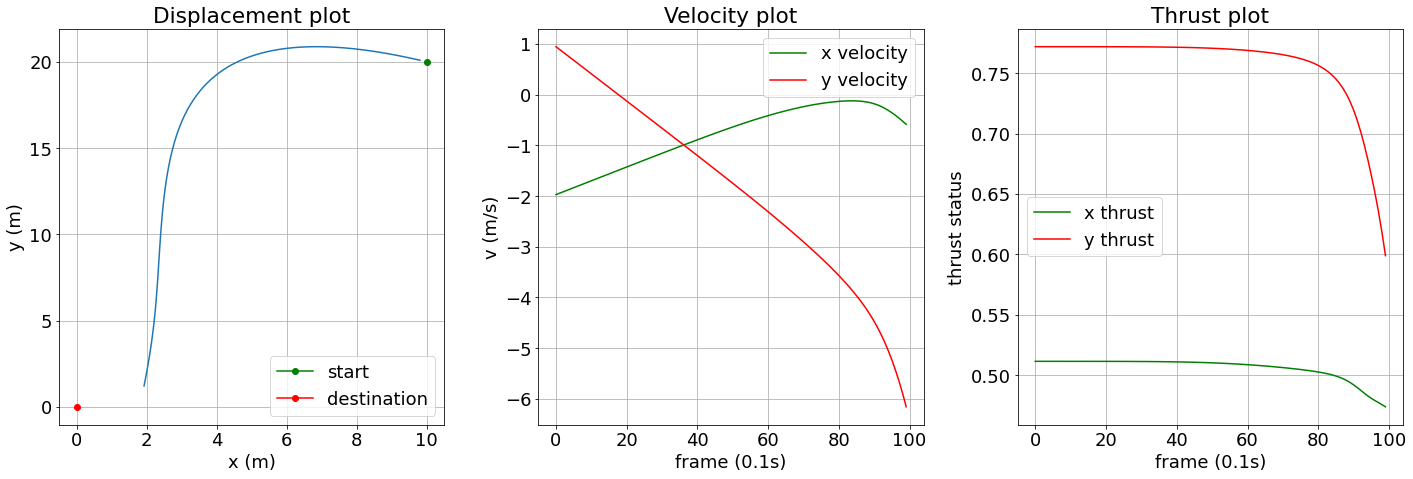

[17] loss: 42.149
[18] loss: 41.322
[19] loss: 40.757
[20] loss: 40.314
[21] loss: 39.927


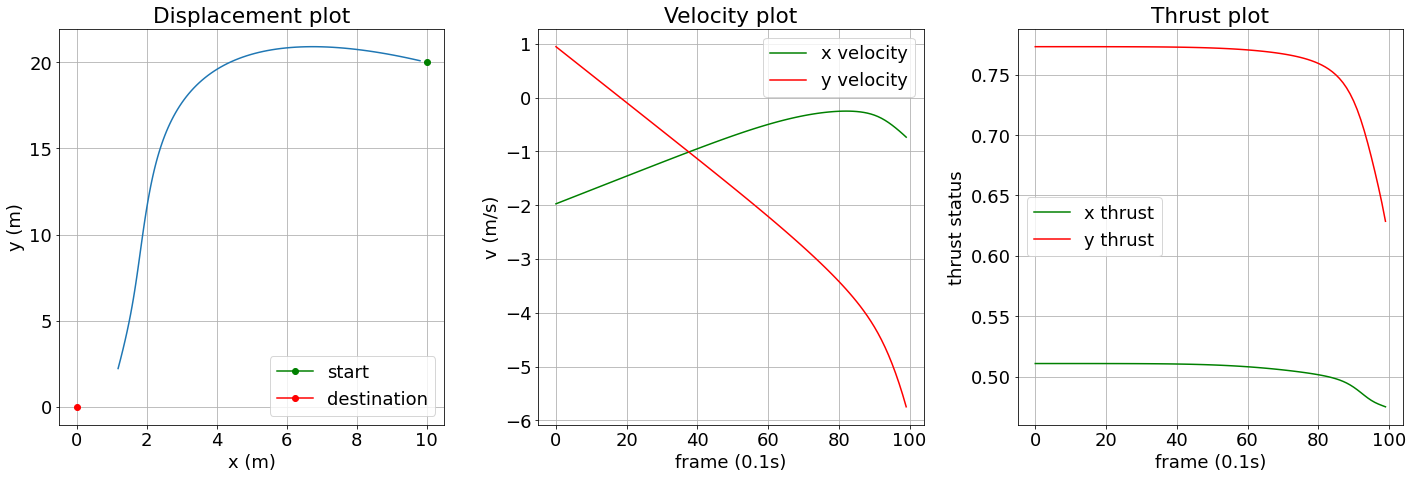

[22] loss: 39.588
[23] loss: 39.201
[24] loss: 38.544
[25] loss: 37.469
[26] loss: 35.587


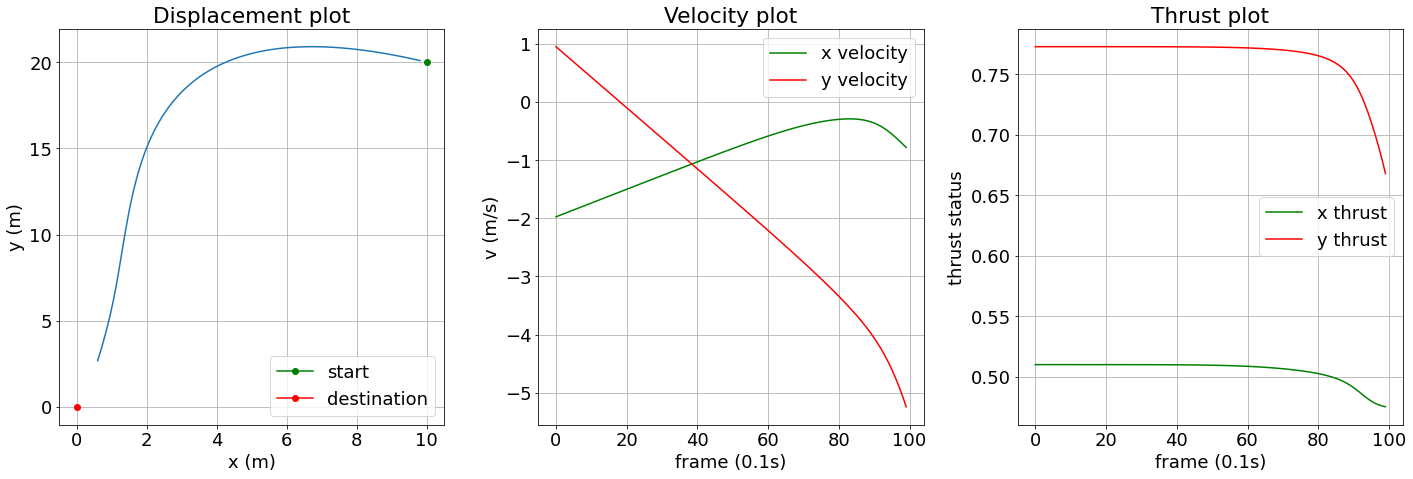

[27] loss: 31.852
[28] loss: 30.143
[29] loss: 28.417
[30] loss: 26.783
[31] loss: 25.267


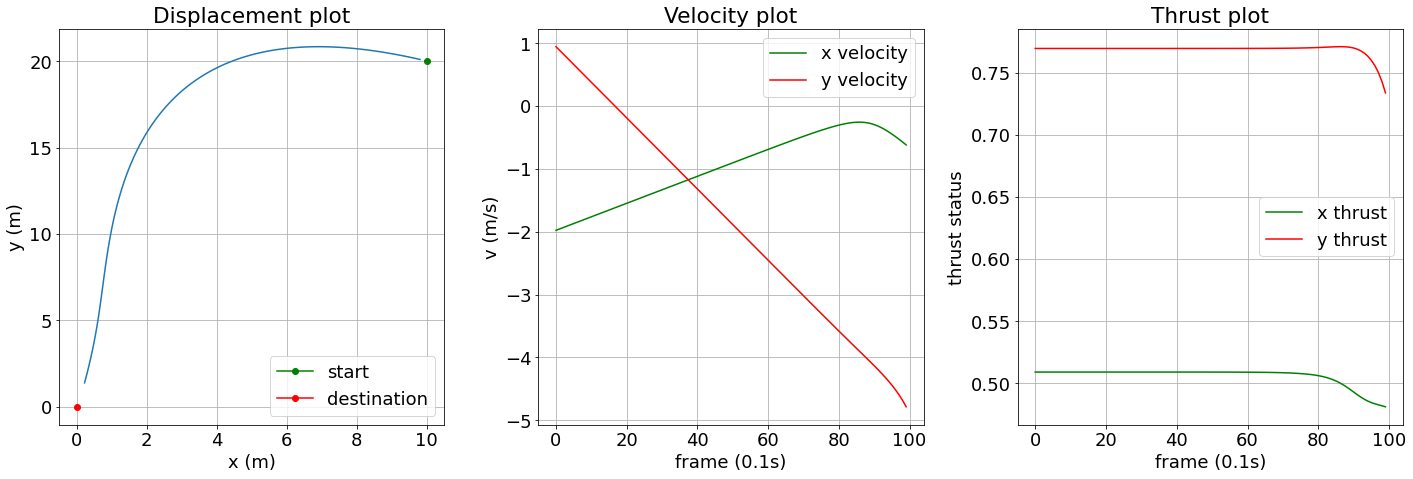

[32] loss: 23.747
[33] loss: 22.080
[34] loss: 20.053
[35] loss: 17.524
[36] loss: 14.903


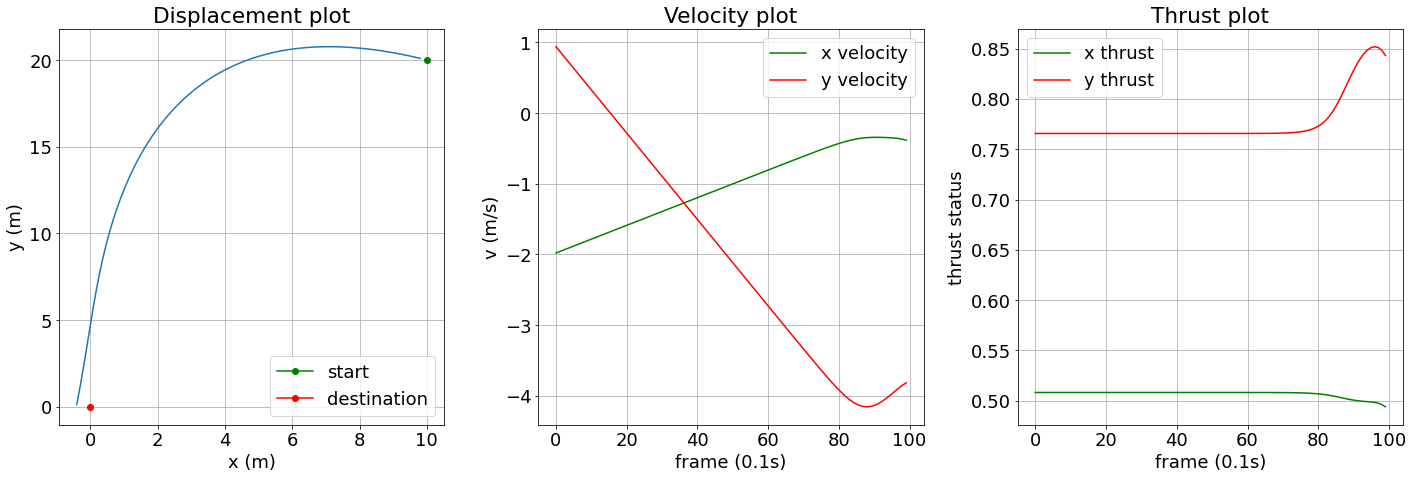

[37] loss: 12.445
[38] loss: 9.377
[39] loss: 5.849
[40] loss: 4.167
[41] loss: 3.007


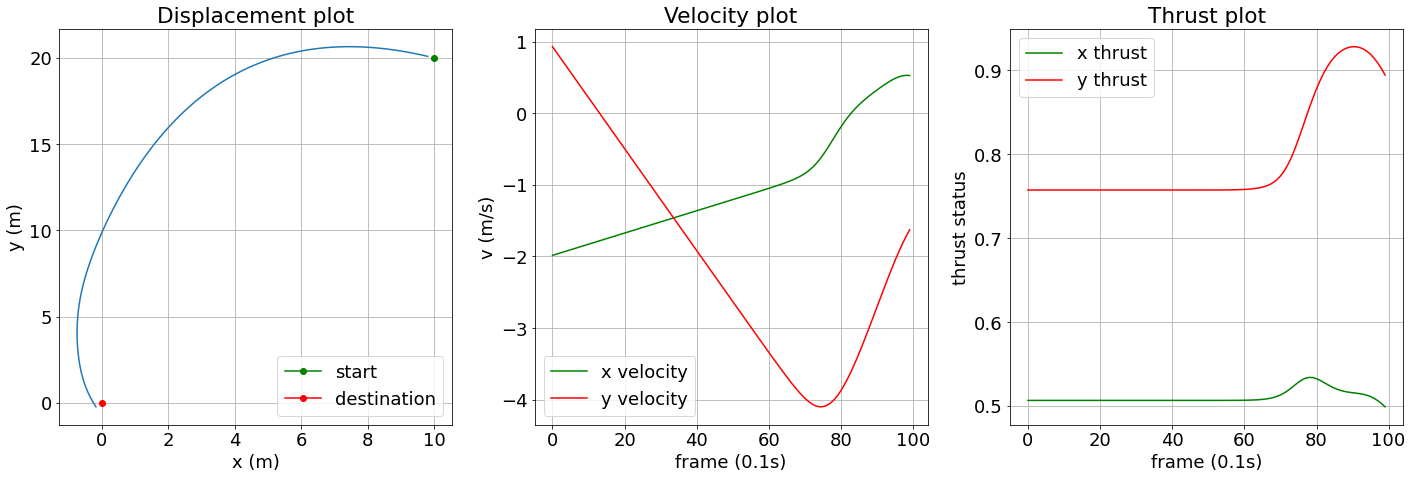

[42] loss: 2.212
[43] loss: 1.641
[44] loss: 1.216
[45] loss: 0.929
[46] loss: 0.725


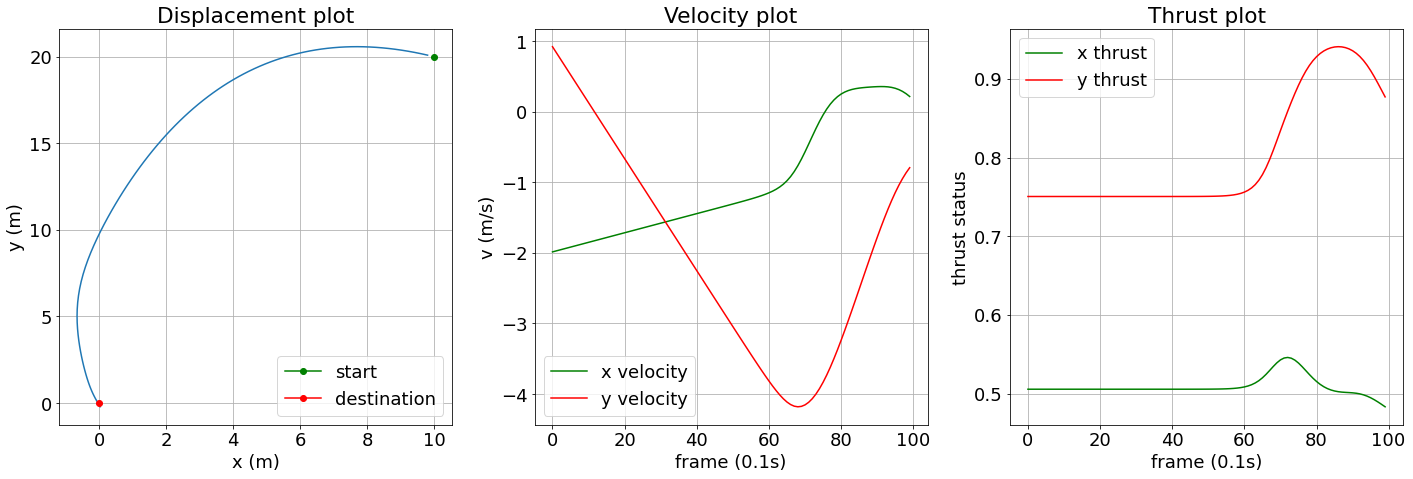

[47] loss: 0.574
[48] loss: 0.457
[49] loss: 0.366
[50] loss: 0.295
[51] loss: 0.238


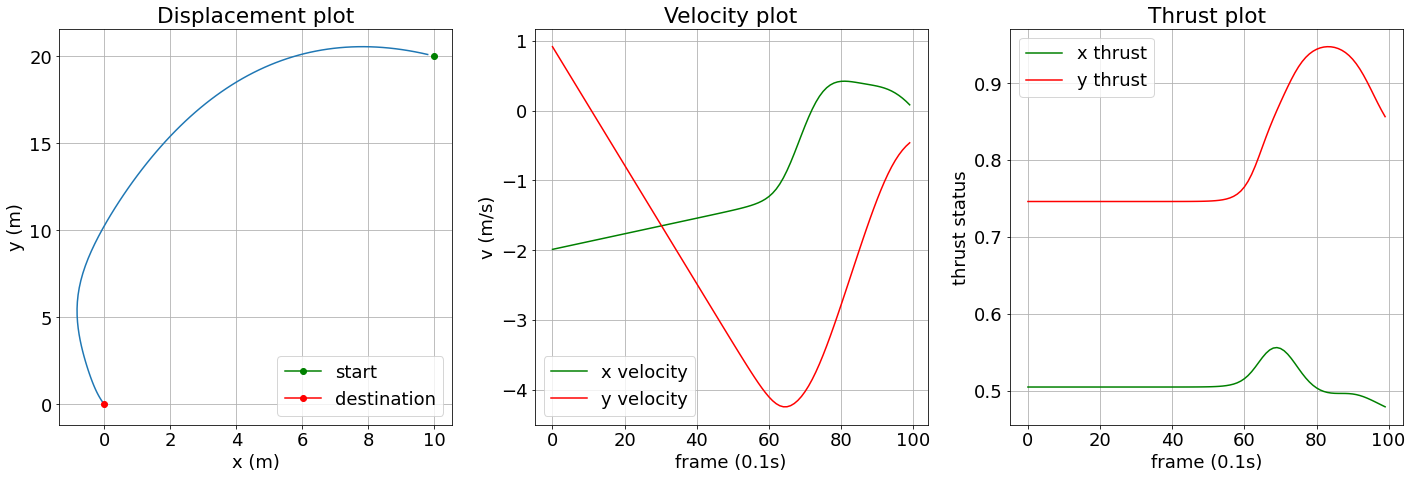

[52] loss: 0.193
[53] loss: 0.157
[54] loss: 0.127
[55] loss: 0.104
[56] loss: 0.084


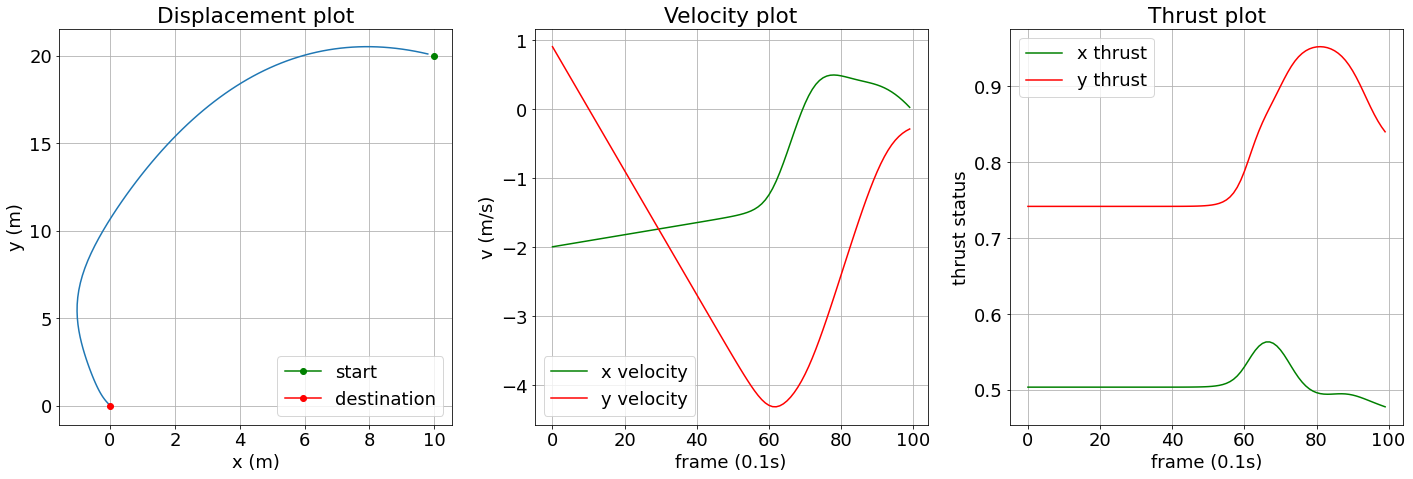

[57] loss: 0.069
[58] loss: 0.055
[59] loss: 0.042
[60] loss: 0.032


In [36]:
# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(60)  # solve the optimization problem